In [19]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import time


if 1: # linux
    allMem = pd.read_csv('/home/wade/Documents/Datasets/congressional-voting-records/HSall_members.csv')
    allPty = pd.read_csv('/home/wade/Documents/Datasets/congressional-voting-records/HSall_parties.csv')
    allRol = pd.read_csv('/home/wade/Documents/Datasets/congressional-voting-records/HSall_rollcalls.csv',low_memory=False)
    allVte = pd.read_csv('/home/wade/Documents/Datasets/congressional-voting-records/HSall_votes.csv')
    cast_codes = pd.read_csv('/home/wade/codingCoop/congress/data/cast_codes.csv')
    
if 0: # unix
    allMem = pd.read_csv('/Volumes/NO NAME/congressional-voting-records/HSall_members.csv')
    allPty = pd.read_csv('/Volumes/NO NAME/congressional-voting-records/HSall_parties.csv')
    allRol = pd.read_csv('/Volumes/NO NAME/congressional-voting-records/HSall_rollcalls.csv',low_memory=False)
    allVte = pd.read_csv('/Volumes/NO NAME/congressional-voting-records/HSall_votes.csv')



#print(allMem.head())
#print(allPty.head())
print('finished importing data')

finished importing data


In [7]:
print('number of members:',len(allMem['congress']))
print('number of parties:',len(allPty['congress']))
print('number of Rolls:', len(allRol['congress']))
print('number of Votes:', len(allVte['congress']))

print(allVte.head())
print('NXT:')
print(allMem.head())
print('NXT:')
print(allRol.head())
print('NXT:')
print(cast_codes.head())

number of members: 48804
number of parties: 819
number of Rolls: 105254
number of Votes: 24023858
   congress chamber  rollnumber  icpsr  cast_code
0         1   House           1    154          6
1         1   House           1    259          9
2         1   House           1    379          1
3         1   House           1    649          1
4         1   House           1    786          1
NXT:
   congress    chamber  icpsr  state_icpsr  district_code state_abbrev  \
0         1  President  99869           99              0          USA   
1         1      House   4766            1             98           CT   
2         1      House   8457            1             98           CT   
3         1      House   9062            1             98           CT   
4         1      House   9489            1             98           CT   

   party_code  occupancy  last_means                  bioname bioguide_id  \
0        5000        NaN         NaN       WASHINGTON, George         NaN  

In [8]:
# just grab the senate
vteSen = allVte[allVte['chamber']=='Senate']
#print(vteSen.head())
print(len(vteSen), len(allVte))

memSen = allMem[allMem['chamber']=='Senate']
print('Number of senate members:', len(memSen))
#memSen = [print(m) for m in memSen]
#print(len(np.unique(memSen)))
#print(memSen.head())

# grab their icpsr
allIsp = set(vteSen['icpsr'])
print('Number of ISPSR:',len(allIsp))


# grab senate members
memIsp = set(memSen['icpsr'])
print('Number of ISPSR:', len(memIsp))

# These seem about right...
'''
Since the U.S. Congress convened on March 4, 1789, 12,343 individuals 
have served as Representatives, Senators, or in both capacities. There 
have been 10,360 Members who served only as Representatives, 1,305 
Members who served only in the Senate, and 677 Members with service 
in both chambers.
'''


4181474 24023858
Number of senate members: 9583
Number of ISPSR: 1972
Number of ISPSR: 1969


'\nSince the U.S. Congress convened on March 4, 1789, 12,343 individuals \nhave served as Representatives, Senators, or in both capacities. There \nhave been 10,360 Members who served only as Representatives, 1,305 \nMembers who served only in the Senate, and 677 Members with service \nin both chambers.\n'

In [9]:
# Which people am I missing?
missIsp = [i for i in allIsp if i not in memIsp]
print(missIsp)
a = 2307

#df.loc[df['column_name'] == some_value]

[99901, 99902, 99903, 99904, 99905, 99906, 99907, 99908, 99909, 99910, 99911]


In [10]:

# grab info for a vote
# congress chamber  rollnumber
# TODO: fix the output of this guy
def getVoteInfo(cong, cham, rollNum):
    q = "congress == %s and chamber == %s and rollnumber == %s" % (cong, cham, rollNum)
    out = allRol.query(q)
    return out

print(getVoteInfo(114,"'Senate'",3))

# get the text of the cast code
def castTxt(cast):
    q = "cast_code == %s" % (cast)
    out = cast_codes.query(q)
    return out['title']

print(castTxt(4))

# grab the name of a member
def getName(icpsr):
    names = list(memSen.loc[memSen['icpsr']==icpsr]['bioname'])
    
    if len(names) == 0:
        return 'NaN'
    return set(names)


print(getName(14009)) # COCHRAN, William Thad | 14009



# Grab the parties of a member
def getParty(icpsr):
    ptys = list(memSen.loc[memSen['icpsr']==icpsr]['party_code'])
    
    if len(ptys) == 0:
        return 'NaN'
    return ptys



        congress chamber  rollnumber        date  session  clerk_rollnumber  \
104130       114  Senate           3  2015-01-12      1.0               3.0   

        mid_1  mid_2  spread_1  spread_2  log_likelihood bill_number  \
104130 -0.336 -0.459    -0.336    -0.459         -12.217          S1   

                                       vote_result vote_desc vote_question  \
104130  Cloture on the Motion to Proceed Agreed to       NaN           NaN   

       dtl_desc  
104130      NaN  
4    Announced Nay
Name: title, dtype: object
{'COCHRAN, William Thad'}


In [23]:
thresh = 114 # select only a particular range of congress from 1 to 155. ie. 100 = 1988
vteSenThresh = vteSen[vteSen['congress']==thresh]

# some basic stats of the votes we're looking at
print('Number of rolls:', len(vteSenThresh))
print('Number of votes:', len(set(vteSenThresh['rollnumber'])))
print(len(vteSenThresh) / len(set(vteSenThresh['rollnumber'])))

if 0:
    print(len(vteSenThresh[vteSenThresh['rollnumber'] == 4]))
    print(set(vteSenThresh['rollnumber']))
    #vteSenThresh.tail()

vteSenThresh.tail()

Number of rolls: 50200
Number of votes: 502
100.0


,congress,chamber,rollnumber,icpsr,cast_code
23816717,114,Senate,502,49308,6
23816718,114,Senate,502,49700,6
23816719,114,Senate,502,49703,1
23816720,114,Senate,502,49706,1
23816721,114,Senate,502,94659,6


In [24]:
# determine how parties voted for reach vote

# TODO: do I want this to be for just one vote and one session? or all of them
# TODO: make the output a list of rolls

def get_party_votes():
    
    thresh = 114 # select only a particular range of congress from 1 to 155. ie. 100 = 1988
    vteSenThresh = vteSen[vteSen['congress'] == thresh]
    
    # for each roll number (one bill), grab the votes
    for roll_i in [1]: #set(vteSenThresh['rollnumber']):
        # filter for the current roll
        vteSenThresh_roll = vteSenThresh[vteSenThresh['rollnumber'] == roll_i]
        #print(len(vteSenThresh_roll))
        #print(len(set(vteSenThresh_roll['rollnumber'])))
        #print(len(set(vteSenThresh_roll['icpsr']))) # debugging
        
        allCasts = vteSenThresh_roll['cast_code'] # grab the votes
        allParties = [getParty(memnum)[0] for memnum in vteSenThresh_roll['icpsr']]
        allMems = vteSenThresh_roll['icpsr']
        
        
    return allCasts, allParties, allMems

cst, pty, mem = get_party_votes()

print(len(cst),len(pty), len(mem))



100 100 100


In [17]:
# grab some basic info about the range of votes and parties returned
print(len(cst),len(pty))
print(type(list(cst)),type(pty))
print(set(cst))
print(set(pty))

if 0: # some more exploration of the data
    cst.hist() # lot's of 1's 6's and 9's

    pty = [_ for _ in pty if _ != 'N']
    print(len(pty))
    ptyS = pd.Series(pty)
    ptyS.hist(bins=len(set(ptyS))) # 100 D, 200 R, 328 I

    
    Counter(ptyS) # how many of each party?
    Counter(pty)

100 100
<class 'list'> <class 'list'>
{1, 6, 9}
{200, 328, 100}


In [39]:
# now let's grab the parties votes (Just R and D and I for now)
# this should be used on one roll only
# 100 D, 200 R, 328 I

def tabulateRollVotes(cst,pty,congress,roll, verbose=False):
    
    D_vtes = []
    R_vtes = []
    I_vtes = []
    for c,p in zip(list(cst), pty):
        if p == 100:
            D_vtes.append(c)
        elif p == 200:
            R_vtes.append(c)
        elif p == 328:
            I_vtes.append(c)
    
    totals = Counter(D_vtes) + Counter(R_vtes) + Counter(I_vtes)
    
    if verbose:
        print('For Congress:',congress, ' and Roll:', roll)
        print('lengths:',(len(R_vtes)+len(D_vtes)+len(I_vtes)),len(cst),'(should be equal)')
        print('D', Counter(D_vtes))
        print('R', Counter(R_vtes))
        print('I', Counter(I_vtes))
        print('Totals:', totals)
        
    
    # package it up
    tabedVotes = {}
    tabedVotes['congress'] = congress
    tabedVotes['roll'] = roll
    tabedVotes['totals'] = totals
    tabedVotes['100'] = Counter(D_vtes)
    tabedVotes['200'] = Counter(R_vtes)
    tabedVotes['328'] = Counter(I_vtes)
    
    
    return tabedVotes 

        

"""
testing: for roll 1 of the 114 congress:
https://www.govtrack.us/congress/votes/114-2015/s1
They got 31 - 66 rejected
I got 31 - 66 with 3 abstains

D Counter({1: 30, 6: 12, 9: 2})
R Counter({6: 53, 9: 1})
I Counter({1: 1, 6: 1})

Hey it works (and the data seems correct)
"""
rollVotes = tabulateRollVotes(cst,pty,114,1)
rollVotes['totals']

Counter({1: 31, 9: 3, 6: 66})

In [44]:
# does a member vote with their party or against their party for a roll?
# is this easier for yes votes vs no votes? 
# what about new members? Does this change anything? 
# -> I need to calculate how many 'new' members there are

# what is the break down of votes for each member? 
# -> ie. is one member more likley to vote yes or no in general? 

vteSenThresh.tail()

,congress,chamber,rollnumber,icpsr,cast_code
23816717,114,Senate,502,49308,6
23816718,114,Senate,502,49700,6
23816719,114,Senate,502,49703,1
23816720,114,Senate,502,49706,1
23816721,114,Senate,502,94659,6


In [45]:
# Grab all of the votes for one member
def grabAllMemVotes(ICPSR, data):
    vteSenThreshMem = vteSenThresh[vteSenThresh['icpsr']==ICPSR]
    
    # finish this 
    
    
    return vteSenThreshMem

memVotes = grabAllMemVotes(49308, ' ')
memVotes.head()

,congress,chamber,rollnumber,icpsr,cast_code
23766617,114,Senate,1,49308,1
23766717,114,Senate,2,49308,1
23766817,114,Senate,3,49308,6
23766917,114,Senate,4,49308,6
23767017,114,Senate,5,49308,6


Counter({1: 30, 9: 2, 6: 12})

In [61]:
###########################################################
# compare the vote for one member to the votes of the party

def compareMemVotes(ICPSR, congress, roll):
    
    
    rollVotes = tabulateRollVotes(cst,pty,congress, roll)
    memberParty = str(getParty(ICPSR)[0])
    partyVotes = rollVotes[memberParty] # grab how the party voted for a roll and bill
    memVoteRow = vteSenThresh[(vteSenThresh['congress']==congress) & (vteSenThresh['rollnumber']==roll) & (vteSenThresh['icpsr']==ICPSR)]
    print(memVoteRow)
    memVote = int(memVoteRow['cast_code'])
    print(memVote)
    print(partyVotes)
    partyVote = max(partyVotes, key=partyVotes.get)
    votePct = partyVotes[partyVote] / 100
    
    print('Member %s (%s) voted %s and the party %s voted %s (%s)' %(getName(ICPSR).pop(), ICPSR, memVote,memberParty,partyVote, votePct))

compareMemVotes(49308, 114, 1, rollVotes)

'''
TESTING
this checks out with https://www.govtrack.us/congress/votes/114-2015/s1
for congress = 114 and roll = 1

myOut: 
Member MURRAY, Patty (49308) voted 1 and the party 100 voted 1 (0.3)

'''

          congress chamber  rollnumber  icpsr  cast_code
23766617       114  Senate           1  49308          1
1
Counter({1: 30, 6: 12, 9: 2})
Member MURRAY, Patty (49308) voted 1 and the party 100 voted 1 (0.3)


In [ ]:
# OLD STUFF

In [61]:
# how do the party affiliations change over time? (Senate)
# very slow... 

thresh = 100 # select only a particular range of congress from 1 to 155. ie. 100 = 1988
vteSenThresh = vteSen[vteSen['congress']>=thresh]


ptyCnts = []
ptyBuff = []
currentCong = thresh
start = time.time()
print('Start...')
for index, row in vteSenThresh.iterrows():
    
    if index % 100000 == 0:
        print(int(row['congress']),currentCong)
    
    if int(row['congress']) != currentCong:
        print(currentCong,end=" ")
        currentCong = int(row['congress'])
        numPty = len(set(ptyBuff))
        #print(numPty)
        ptyCnts.append(numPty)
        ptyBuff = []
    
    isp = int(row['icpsr'])
    pty = getParty(isp)
    ptyBuff.append(pty[0])

    
    
    
    


Start...
100 100
100 101 101
101 102 102
102 103 104 104
104 105 105
105 

KeyboardInterrupt: 

In [60]:
print(len(set(vteSen['congress'])))

ptyCnts
vteSenThresh = vteSen[vteSen['congress']>=thresh]

len(vteSenThresh)


115


1013961

Num party Counts []


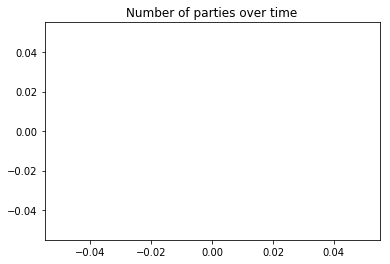

In [54]:
print('Num party Counts', ptyCnts)

if 1:
    plt.plot(ptyCnts)
    plt.title('Number of parties over time')
    plt.show()
    

In [3]:
c1 = roll[roll['congress'] == 3]
max(c1['rollnumber'])

# collect max roll number for each congress
maxRolls = {}
for i in range(1, max(roll['congress'])):
    c = roll[roll['congress'] == i]
    maxRolls[i] = max(c['rollnumber'])

        

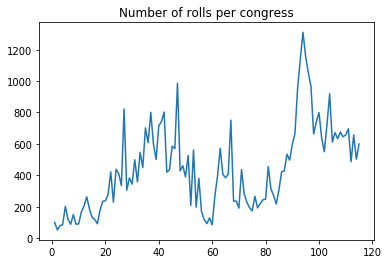

In [51]:
x, y = zip(*maxRolls.items())
if 1:
    plt.plot(x,y)
    plt.title('Number of rolls per congress')
    plt.show()

In [17]:
import RollCodes
rc = RollCodes.rollCodes # grab the data

In [48]:
# calculate the yay nay ratio for n congress
import time

thresh = 75
df = roll[roll['congress'] > thresh]

start = time.time()
ynRat = []

compMin = (((max(df['congress'])-thresh) / 10) * 99) / 60
print('Thinking... (est time', compMin, ') minutes')
for i in range(min(df['congress']),max(df['congress'])):
    c = df[df['congress'] == i]

    yay,nay = 0,0
    for index, row in c.iterrows():
        if row['cast_code'] == 1:
            yay += 1
        elif row['cast_code'] == 6:
            nay += 1
            
    ynRat.append(yay/nay)
    
print('Took:', time.time()-start, 'seconds to run', max(df['congress']))
# takes 99 seconds to run 10
#       252               41 

Took: 252.9785554409027 seconds to run 116


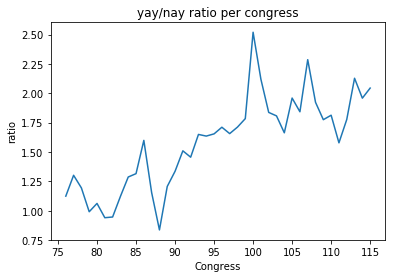

[1.1241386735572783,
 1.3017911456573166,
 1.1941489361702127,
 0.991407574901074,
 1.0621604680317593,
 0.9405786638529461,
 0.946649210375583,
 1.1219934577640946,
 1.2871213065702531,
 1.3157318741450068]

In [49]:
if 1:
    plt.plot(range(min(df['congress']),max(df['congress'])),ynRat)
    plt.title('yay/nay ratio per congress')
    plt.xlabel('Congress')
    plt.ylabel('ratio')
    plt.show()



In [114]:
# Let's grab the names and parties
npty = pd.read_csv('data/ICPS.csv')
print(npty.head())
len(npty['icps'])

   congress  icps  state  dist stateName party        name  \
0         1  4998      1     0   CONNECT  5000     JOHNSON   
1         1  2936      1     0   CONNECT  5000   ELLSWORTH   
2         1   507     11     0   DELAWAR  4000     BASSETT   
3         1  7762     11     0   DELAWAR  5000        READ   
4         1  3128     44     0   GEORGIA  4000         FEW   

                    nameLong  
0    JOHNSON, WILLIAM SAMUEL  
1          ELLSWORTH, OLIVER  
2           BASSETT, RICHARD  
3               READ, GEORGE  
4               FEW, WILLIAM  


9414

In [132]:
# let's build some useful functions

def get_name(ipr):
    idx = npty[npty['icps'] == ipr].index.tolist()
    nms = [npty.loc[id_,'name'] for id_ in idx]
    return nms 

def get_party(ipr):
    idx = npty[npty['icps'] == str(ipr)].index.tolist()
    ptys = [npty.loc[id_,'party'] for id_ in idx]
    #ptys = [int(pt) for pt in ptys]
    
    ptys_ = []
    for p in ptys:
        if '*' in p: # deal with *
            ptys_.append(int(p[2:len(p)]))
        else:
            ptys_.append(int(p))
    return ptys_
    
# 1536

npty.loc[4,'state']

npty.loc[38,'name']
print(get_party(99911))
print(get_name(99911))

npty['icps'] == 99911

# 9094
npty.loc[9093,'icps']

len(npty[npty['icps'] == '99911'])
print(get_party(21166))

[100, 100, 100]
[]
[]


Number of votes for 1366.000000: 597.000000
took 29.209765672683716


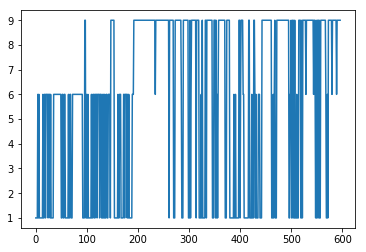

In [106]:
# Let's find how one person votes over time

thresh = 110 
df = roll[roll['congress'] > thresh]
df.head()

# grab the votes for the member
memb = 1366
votes = [] #todo dict?
start = time.time()
for index, row in df.iterrows():
    if row['icpsr'] == memb:
        votes.append(row['cast_code'])

print('Number of votes for %f: %f' %(memb, len(votes)))

print('took', (time.time() - start))

plt.plot(votes)
plt.show()




In [85]:
tst = df.head()
tst = tst.copy(deep=True)

tst['party'] = [1,0,0,1,1]

# add party to data

# make the party column
partys = []
for index, row in tst.iterrows():
    ptys = get_party(row['icpsr'])
    print(row['icpsr'], ptys)
    
    # there isn't a party
    if len(ptys) == 0:
        ptys = [999]
        
    partys.append(ptys[0])

1366 ['10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10']
4812 ['10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10']
10808 []
14009 []
14101 []


In [133]:
# how impoverished is my party data?
thresh = 110 
df = roll[roll['congress'] > thresh]

# grab unique icpsr's
members = df['icpsr'].unique()

pty = []
for mem in members:
    ptys = get_party(mem)
    
    if len(ptys) > 0:
        pty.append(ptys[0])
    #else:
        #print(mem)
        
print(len(pty),len(members))
print('took', (time.time() - start))
 
        
        

145 178
took 1430.2501866817474


In [ ]:
# 



# are you more likely to see a yay after seeing a nay? Vice versa